In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

In [4]:
train_path = r'Train'
test_path = r'Test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 0 images belonging to 0 classes.


Found 0 images belonging to 0 classes.


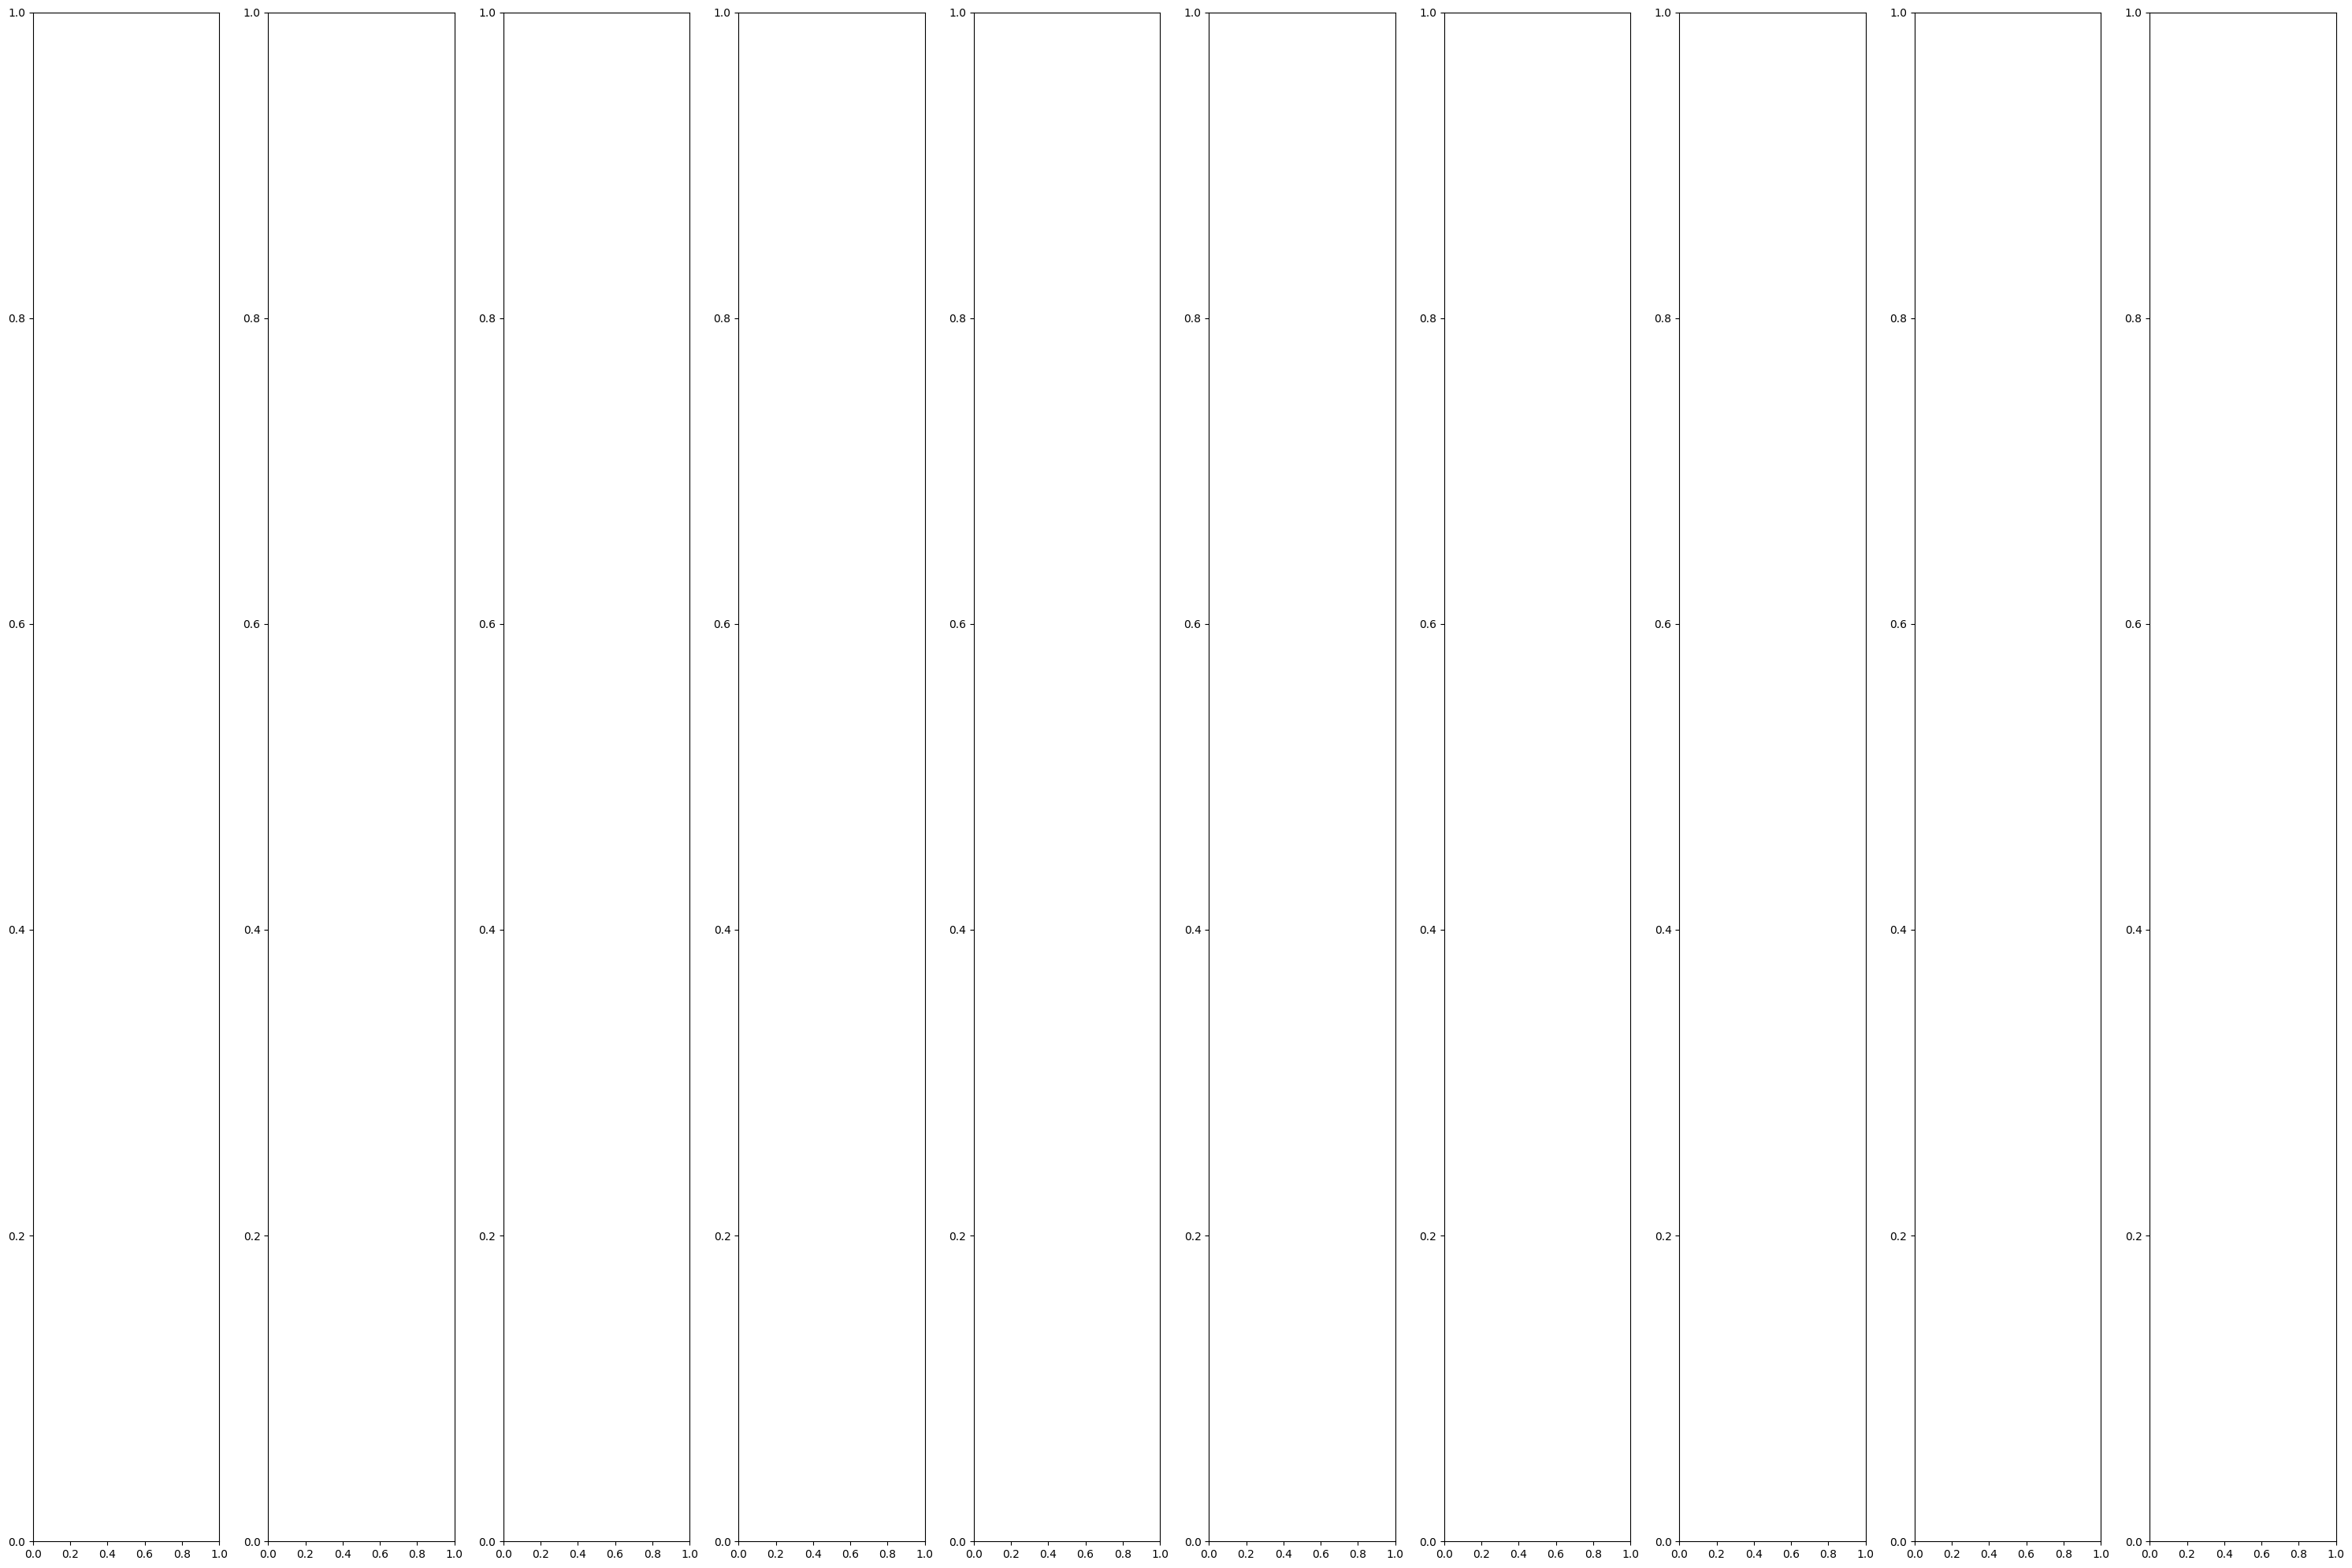

(0, 64, 64, 3)
[]


In [5]:
imgs, labels = next(train_batches)

#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

In [6]:
# Create a Sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Add dense layers with activation functions
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [ ]:
# Compile the model with the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
# Fit the model to your data
history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop], validation_data=test_batches)

In [ ]:
# For getting next batch of testing imgs...
imgs, labels = next(test_batches) 

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


#Once the model is fitted we save the model using model.save()  function.


model.save('model.h5')

In [ ]:
word_dict = {0:'One',1:'Two',2:'Three',3:'Four',4:'Five',5:'Six',6:'Seven',7:'Eight',8:'Nine',9:'A',10:'B',11:'C',12:'D',13:'E',14:'F',15:'G',16:'H',17:'I',18:'J',19:'K',20:'L',21:'M',22:'N',23:'0',24:'P',25:'Q',26:'R',27:'S',28:'T',29:'U',30:'V',31:'W',32:'X',33:'Y',34:'Z',}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')

plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')

In [ ]:
model = keras.models.load_model(r"model.h5")

background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [ ]:
def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [ ]:
import cv2

def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    _, thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    # Fetching contours in the frame (These contours can be of hand or any other object in foreground)...
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If the length of contours list = 0, it means we didn't get any contours...
    if len(contours) == 0:
        return None
    else:
        # The largest external contour should be the hand 
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        # Returning the hand segment (max contour) and the thresholded image of the hand...
        return (thresholded, hand_segment_max_cont)

In [ ]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame...
    
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)


    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
  (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        # segmenting the hand region
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
      ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Thesholded Hand Image", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,
 cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,
(1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)],
(170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,
    ROI_bottom), (255,128,0), 3)

    # incrementing the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.putText(frame_copy, "Sign Recognition",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)


    # Close windows with Esc
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()